# Análise de Desbalanceamento e Estratégias de Categorização

Este notebook analisa o desbalanceamento extremo das variáveis alvo e testa diferentes estratégias de agrupamento.

## 1. Carregamento e Preparação dos Dados

In [1]:
# Setup completo com verificações defensivas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Carregar dataset
csv_path = r"c:\Users\fabio\Desktop\MBA\laboratorios\defesa\df_defesa_civil_final.csv"
df_final = pd.read_csv(csv_path)

print(f"Dataset shape: {df_final.shape}")
print(f"Columns: {len(df_final.columns)}")

# Criar variável agregada de impacto humano (mortos + feridos)
agg_cols = ['DH_MORTOS', 'DH_FERIDOS']
if all(c in df_final.columns for c in agg_cols):
    df_final['DH_mortos_feridos'] = (
        df_final['DH_MORTOS'].fillna(0) + 
        df_final['DH_FERIDOS'].fillna(0)
    )
    print("✓ Variável agregada DH_mortos_feridos criada")

# Definir targets
targets = [
    'DH_mortos_feridos',
    'DH_total_danos_humanos_diretos',
    'DM_total_danos_materiais',
    'PEPL_total_publico',
    'PEPR_total_privado'
]

display(df_final.head())

Dataset shape: (22307, 76)
Columns: 76
✓ Variável agregada DH_mortos_feridos criada


,Protocolo_S2iD,Nome_Municipio,Sigla_UF,regiao,Data_Registro,Data_Evento,Cod_Cobrade,tipologia,descricao_tipologia,grupo_de_desastre,...,hierarquia_urbana,semiarido,populacao,proporcao_cobertura_total_atencao_basica,DH_mortos_feridos,DH_mortos_feridos_cat,DH_total_danos_humanos_diretos_cat,DM_total_danos_materiais_cat,PEPL_total_publico_cat,PEPR_total_privado_cat
0,SC-F-4218301-14110-20190801,Três Barras,SC,Sul,2020-01-20 09:11:30,2019-08-01,14110,4,Estiagem e Seca,Climatológico,...,Centro Sub-Regional,Não,19455,100.00,0,Nenhum Dano,Q2 (Médio-Baixo),Zero,Q1 (Baixo),Zero
1,SC-F-4204194-14110-20190813,Chapadão do Lageado,SC,Sul,2020-01-14 08:57:52,2019-08-13,14110,4,Estiagem e Seca,Climatológico,...,Centro Local,Não,3025,100.00,0,Nenhum Dano,Zero,Zero,Zero,Q3 (Médio-Alto)
2,MG-F-3170529-14110-20190901,Urucuia,MG,Sudeste,2020-01-30 18:41:40,2019-09-01,14110,4,Estiagem e Seca,Climatológico,...,Centro Local,Sim,17470,100.00,0,Nenhum Dano,Q4 (Alto),Zero,Q3 (Médio-Alto),Q4 (Alto)
3,ES-F-3204658-14132-20190909,São Domingos do Norte,ES,Sudeste,2020-03-06 12:17:08,2019-09-09,14132,6,Incêndio Florestal,Climatológico,...,Centro Local,Não,8735,79.88,0,Nenhum Dano,Zero,Zero,Zero,Zero
4,ES-F-3204658-14132-20190918,São Domingos do Norte,ES,Sudeste,2020-03-12 14:04:14,2019-09-18,14132,6,Incêndio Florestal,Climatológico,...,Centro Local,Não,8735,79.88,0,Nenhum Dano,Zero,Zero,Zero,Zero


## 2. Análise Detalhada de Desbalanceamento

In [2]:
# Análise estatística detalhada do desbalanceamento
print("="*100)
print("ANÁLISE DE DESBALANCEAMENTO - ESTATÍSTICAS DETALHADAS")
print("="*100)

desbalance_stats = []

for target in targets:
    if target in df_final.columns:
        data = df_final[target].fillna(0)
        
        # Estatísticas básicas
        total = len(data)
        zeros = (data == 0).sum()
        non_zeros = (data > 0).sum()
        
        # Percentis dos valores não-zero
        data_nonzero = data[data > 0]
        
        stats = {
            'Target': target,
            'Total_Obs': total,
            'Zeros': zeros,
            'Zeros_%': (zeros/total*100),
            'Non_Zeros': non_zeros,
            'Non_Zeros_%': (non_zeros/total*100),
            'Mean_All': data.mean(),
            'Median_All': data.median(),
            'Mean_NonZero': data_nonzero.mean() if len(data_nonzero) > 0 else 0,
            'Median_NonZero': data_nonzero.median() if len(data_nonzero) > 0 else 0,
            'P25_NonZero': data_nonzero.quantile(0.25) if len(data_nonzero) > 0 else 0,
            'P75_NonZero': data_nonzero.quantile(0.75) if len(data_nonzero) > 0 else 0,
            'P90_NonZero': data_nonzero.quantile(0.90) if len(data_nonzero) > 0 else 0,
            'Max': data.max(),
            'Std': data.std(),
            'Skewness': data.skew()
        }
        
        desbalance_stats.append(stats)
        
        print(f"\n{'─'*100}")
        print(f"📊 {target}")
        print(f"{'─'*100}")
        print(f"   Zeros: {zeros:,} ({stats['Zeros_%']:.1f}%)")
        print(f"   Não-zeros: {non_zeros:,} ({stats['Non_Zeros_%']:.1f}%)")
        print(f"   Média (todos): {stats['Mean_All']:.2f} | Mediana: {stats['Median_All']:.2f}")
        if len(data_nonzero) > 0:
            print(f"   Média (>0): {stats['Mean_NonZero']:.2f} | Mediana (>0): {stats['Median_NonZero']:.2f}")
            print(f"   Percentis não-zero: P25={stats['P25_NonZero']:.1f} | P75={stats['P75_NonZero']:.1f} | P90={stats['P90_NonZero']:.1f}")
        print(f"   Máximo: {stats['Max']:.0f} | Desvio-padrão: {stats['Std']:.2f}")
        print(f"   Assimetria (skewness): {stats['Skewness']:.2f}")

# Criar DataFrame com estatísticas
df_stats = pd.DataFrame(desbalance_stats)
print("\n" + "="*100)
print("RESUMO COMPARATIVO")
print("="*100)
display(df_stats[['Target', 'Zeros_%', 'Non_Zeros_%', 'Mean_NonZero', 'P90_NonZero', 'Max']])

ANÁLISE DE DESBALANCEAMENTO - ESTATÍSTICAS DETALHADAS

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 DH_mortos_feridos
────────────────────────────────────────────────────────────────────────────────────────────────────
   Zeros: 21,104 (94.6%)
   Não-zeros: 1,203 (5.4%)
   Média (todos): 1.78 | Mediana: 0.00
   Média (>0): 33.04 | Mediana (>0): 3.00
   Percentis não-zero: P25=1.0 | P75=12.0 | P90=43.8
   Máximo: 6871 | Desvio-padrão: 62.32
   Assimetria (skewness): 93.34

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 DH_total_danos_humanos_diretos
────────────────────────────────────────────────────────────────────────────────────────────────────
   Zeros: 9,806 (44.0%)
   Não-zeros: 12,501 (56.0%)
   Média (todos): 2245.69 | Mediana: 8.00
   Média (>0): 4007.25 | Mediana (>0): 1000.00
   Percentis não-zero: P25=49.0 | P75=4350.0 | P90=10415.0
   Máximo: 460000 | Desvio-pa

,Target,Zeros_%,Non_Zeros_%,Mean_NonZero,P90_NonZero,Max
0,DH_mortos_feridos,94.607074,5.392926,3.304073e+01,4.380000e+01,6.871000e+03
1,DH_total_danos_humanos_diretos,43.959295,56.040705,4.007248e+03,1.041500e+04,4.600000e+05
2,DM_total_danos_materiais,68.225221,31.774779,6.973726e+06,7.994110e+06,7.744338e+09
3,PEPL_total_publico,49.020487,50.979513,1.184328e+06,2.619453e+06,5.023277e+08
4,PEPR_total_privado,52.284036,47.715964,2.092021e+07,4.431840e+07,6.601106e+09


## 2.5. Detecção e Remoção de Outliers

Antes de categorizar, vamos identificar valores suspeitos/irrealistas comparando danos humanos com a população do município.

ANÁLISE DE OUTLIERS - DANOS HUMANOS / POPULAÇÃO

📊 Estatísticas do Ratio (Danos Humanos / População):
   Total de registros com ratio > 0: 12,501
   Média: 0.2554
   Mediana: 0.0695
   P95: 0.9874
   P99: 1.0937
   P99.9: 1.5088
   Máximo: 8.2798

⚠️ Casos com Ratio > 1.0 (danos > população): 418

Top 10 casos mais extremos:


,regiao,Nome_Municipio,grupo_de_desastre,DH_total_danos_humanos_diretos,populacao,ratio_danos_humanos_pop
15543,Norte,Japurá,Climatológico,14531,1755,8.279772
11331,Norte,Japurá,Climatológico,13584,1755,7.740171
20756,Norte,Japurá,Climatológico,5205,1755,2.965812
9872,Norte,Japurá,Hidrológico,3005,1755,1.712251
2924,Nordeste,Severiano Melo,Climatológico,2900,1743,1.663798
7186,Sul,Engenho Velho,Climatológico,1530,932,1.641631
13192,Sul,Engenho Velho,Climatológico,1530,932,1.641631
16426,Nordeste,Porto da Folha,Climatológico,45650,28788,1.585730
15430,Norte,Atalaia do Norte,Climatológico,31562,20868,1.512459
1853,Nordeste,Maetinga,Climatológico,3600,2386,1.508801


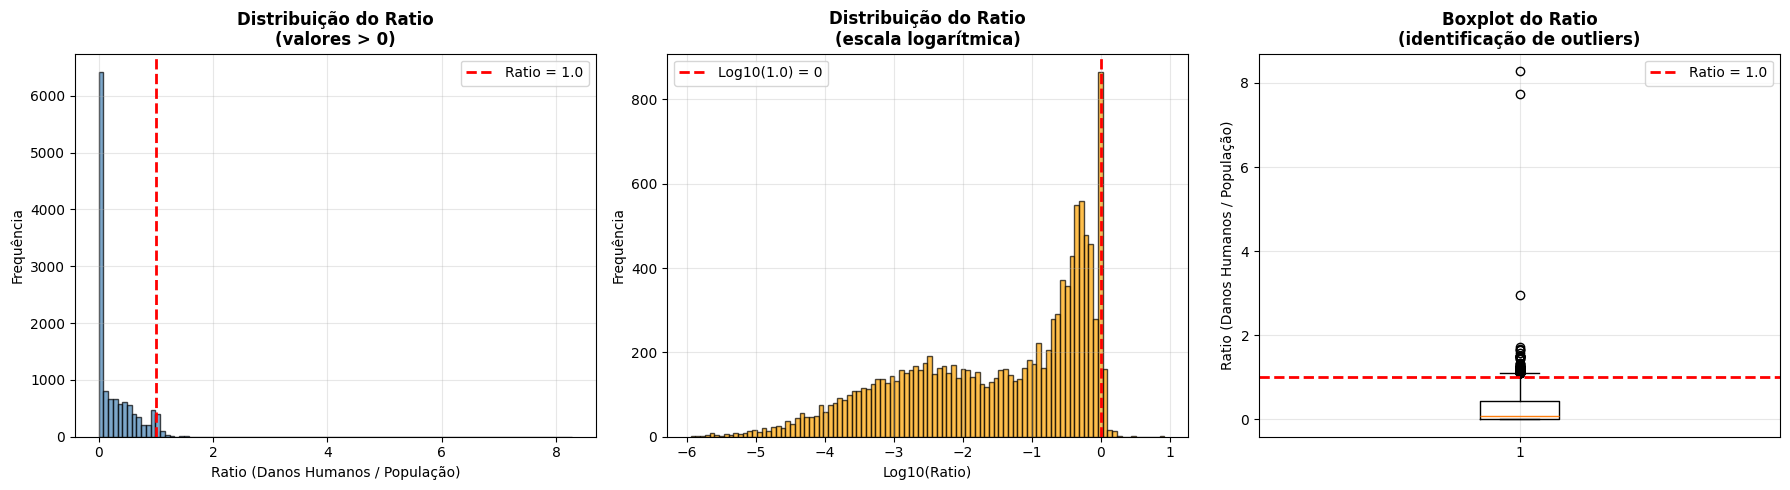


📈 Análise de Outliers (método IQR):
   Q1 (25%): 0.0026
   Q3 (75%): 0.4421
   IQR: 0.4395
   Upper Fence (Q3 + 1.5*IQR): 1.1014
   Extreme Fence (Q3 + 3.0*IQR): 1.7606
   
   Outliers (> upper fence): 118 (0.94%)
   Outliers extremos (> extreme fence): 3 (0.02%)


In [3]:
# Análise de outliers: Danos Humanos vs População
print("="*100)
print("ANÁLISE DE OUTLIERS - DANOS HUMANOS / POPULAÇÃO")
print("="*100)

# Criar ratio para análise
df_final['ratio_danos_humanos_pop'] = (
    df_final['DH_total_danos_humanos_diretos'] / df_final['populacao']
).replace([np.inf, -np.inf], np.nan)

# Estatísticas do ratio (apenas valores > 0)
ratio_nonzero = df_final[df_final['ratio_danos_humanos_pop'] > 0]['ratio_danos_humanos_pop']

print(f"\n📊 Estatísticas do Ratio (Danos Humanos / População):")
print(f"   Total de registros com ratio > 0: {len(ratio_nonzero):,}")
print(f"   Média: {ratio_nonzero.mean():.4f}")
print(f"   Mediana: {ratio_nonzero.median():.4f}")
print(f"   P95: {ratio_nonzero.quantile(0.95):.4f}")
print(f"   P99: {ratio_nonzero.quantile(0.99):.4f}")
print(f"   P99.9: {ratio_nonzero.quantile(0.999):.4f}")
print(f"   Máximo: {ratio_nonzero.max():.4f}")

# Identificar casos extremos (ratio > 1.0 = mais danos que população!)
casos_extremos = df_final[df_final['ratio_danos_humanos_pop'] > 1.0].copy()
print(f"\n⚠️ Casos com Ratio > 1.0 (danos > população): {len(casos_extremos)}")

if len(casos_extremos) > 0:
    # Mostrar top 10 casos mais extremos
    casos_extremos_top = casos_extremos.nlargest(10, 'ratio_danos_humanos_pop')
    print(f"\nTop 10 casos mais extremos:")
    display(casos_extremos_top[[
        'regiao', 'Nome_Municipio', 'grupo_de_desastre', 
        'DH_total_danos_humanos_diretos', 'populacao', 'ratio_danos_humanos_pop'
    ]])

# Visualizar distribuição do ratio
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Histograma do ratio (valores > 0)
ax1 = axes[0]
ax1.hist(ratio_nonzero, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Ratio (Danos Humanos / População)', fontsize=10)
ax1.set_ylabel('Frequência', fontsize=10)
ax1.set_title('Distribuição do Ratio\n(valores > 0)', fontsize=12, weight='bold')
ax1.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Ratio = 1.0')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Log-transformação
ax2 = axes[1]
log_ratio = np.log10(ratio_nonzero + 1e-6)  # Adicionar pequeno valor para evitar log(0)
ax2.hist(log_ratio, bins=100, color='orange', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Log10(Ratio)', fontsize=10)
ax2.set_ylabel('Frequência', fontsize=10)
ax2.set_title('Distribuição do Ratio\n(escala logarítmica)', fontsize=12, weight='bold')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Log10(1.0) = 0')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Boxplot
ax3 = axes[2]
ax3.boxplot(ratio_nonzero.dropna(), vert=True)
ax3.set_ylabel('Ratio (Danos Humanos / População)', fontsize=10)
ax3.set_title('Boxplot do Ratio\n(identificação de outliers)', fontsize=12, weight='bold')
ax3.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Ratio = 1.0')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas de outliers usando IQR
Q1 = ratio_nonzero.quantile(0.25)
Q3 = ratio_nonzero.quantile(0.75)
IQR = Q3 - Q1
upper_fence = Q3 + 1.5 * IQR
extreme_upper_fence = Q3 + 3.0 * IQR

outliers_iqr = (ratio_nonzero > upper_fence).sum()
extreme_outliers = (ratio_nonzero > extreme_upper_fence).sum()

print(f"\n📈 Análise de Outliers (método IQR):")
print(f"   Q1 (25%): {Q1:.4f}")
print(f"   Q3 (75%): {Q3:.4f}")
print(f"   IQR: {IQR:.4f}")
print(f"   Upper Fence (Q3 + 1.5*IQR): {upper_fence:.4f}")
print(f"   Extreme Fence (Q3 + 3.0*IQR): {extreme_upper_fence:.4f}")
print(f"   \n   Outliers (> upper fence): {outliers_iqr} ({outliers_iqr/len(ratio_nonzero)*100:.2f}%)")
print(f"   Outliers extremos (> extreme fence): {extreme_outliers} ({extreme_outliers/len(ratio_nonzero)*100:.2f}%)")

### Decisão de Remoção de Outliers

Baseado na análise acima, vamos remover casos onde:
1. **Ratio > 1.0**: Danos humanos reportados excedem população total (fisicamente impossível)
2. **Ratio > P99.9**: Casos extremos no top 0.1% (provavelmente erros de registro)

Essa abordagem conservadora mantém 99%+ dos dados enquanto remove valores claramente irrealistas.

In [4]:
# Definir threshold para remoção (ajuste conforme necessário)
THRESHOLD_RATIO = min(1.0, ratio_nonzero.quantile(0.999))  # Menor entre 1.0 e P99.9

print("="*100)
print("REMOÇÃO DE OUTLIERS")
print("="*100)
print(f"\nThreshold escolhido: {THRESHOLD_RATIO:.4f}")
print(f"  (Menor valor entre 1.0 e P99.9 do ratio)")

# Identificar registros a serem removidos
mask_outliers = df_final['ratio_danos_humanos_pop'] > THRESHOLD_RATIO
n_outliers = mask_outliers.sum()

print(f"\n📊 Registros identificados como outliers: {n_outliers:,} ({n_outliers/len(df_final)*100:.2f}%)")

if n_outliers > 0:
    # Mostrar alguns exemplos antes de remover
    print(f"\nExemplos de registros a serem removidos:")
    outliers_sample = df_final[mask_outliers].nlargest(5, 'ratio_danos_humanos_pop')
    display(outliers_sample[[
        'regiao', 'Nome_Municipio', 'grupo_de_desastre',
        'DH_total_danos_humanos_diretos', 'populacao', 'ratio_danos_humanos_pop'
    ]])
    
    # Remover outliers
    df_final_clean = df_final[~mask_outliers].copy()
    
    print(f"\n✓ Outliers removidos")
    print(f"   Shape antes: {df_final.shape}")
    print(f"   Shape depois: {df_final_clean.shape}")
    print(f"   Registros removidos: {n_outliers:,}")
    
    # Atualizar df_final
    df_final = df_final_clean
    
    # Recalcular estatísticas após limpeza
    ratio_clean = df_final[df_final['ratio_danos_humanos_pop'] > 0]['ratio_danos_humanos_pop']
    print(f"\n📊 Estatísticas APÓS remoção de outliers:")
    print(f"   Média: {ratio_clean.mean():.4f} (antes: {ratio_nonzero.mean():.4f})")
    print(f"   Mediana: {ratio_clean.median():.4f} (antes: {ratio_nonzero.median():.4f})")
    print(f"   P99: {ratio_clean.quantile(0.99):.4f} (antes: {ratio_nonzero.quantile(0.99):.4f})")
    print(f"   Máximo: {ratio_clean.max():.4f} (antes: {ratio_nonzero.max():.4f})")
else:
    print("\n✓ Nenhum outlier encontrado com threshold atual")

# Limpar coluna auxiliar
df_final = df_final.drop(columns=['ratio_danos_humanos_pop'], errors='ignore')

REMOÇÃO DE OUTLIERS

Threshold escolhido: 1.0000
  (Menor valor entre 1.0 e P99.9 do ratio)

📊 Registros identificados como outliers: 418 (1.87%)

Exemplos de registros a serem removidos:


,regiao,Nome_Municipio,grupo_de_desastre,DH_total_danos_humanos_diretos,populacao,ratio_danos_humanos_pop
15543,Norte,Japurá,Climatológico,14531,1755,8.279772
11331,Norte,Japurá,Climatológico,13584,1755,7.740171
20756,Norte,Japurá,Climatológico,5205,1755,2.965812
9872,Norte,Japurá,Hidrológico,3005,1755,1.712251
2924,Nordeste,Severiano Melo,Climatológico,2900,1743,1.663798



✓ Outliers removidos
   Shape antes: (22307, 77)
   Shape depois: (21889, 77)
   Registros removidos: 418

📊 Estatísticas APÓS remoção de outliers:
   Média: 0.2252 (antes: 0.2554)
   Mediana: 0.0547 (antes: 0.0695)
   P99: 0.9962 (antes: 1.0937)
   Máximo: 1.0000 (antes: 8.2798)


## 3. Visualização do Desbalanceamento

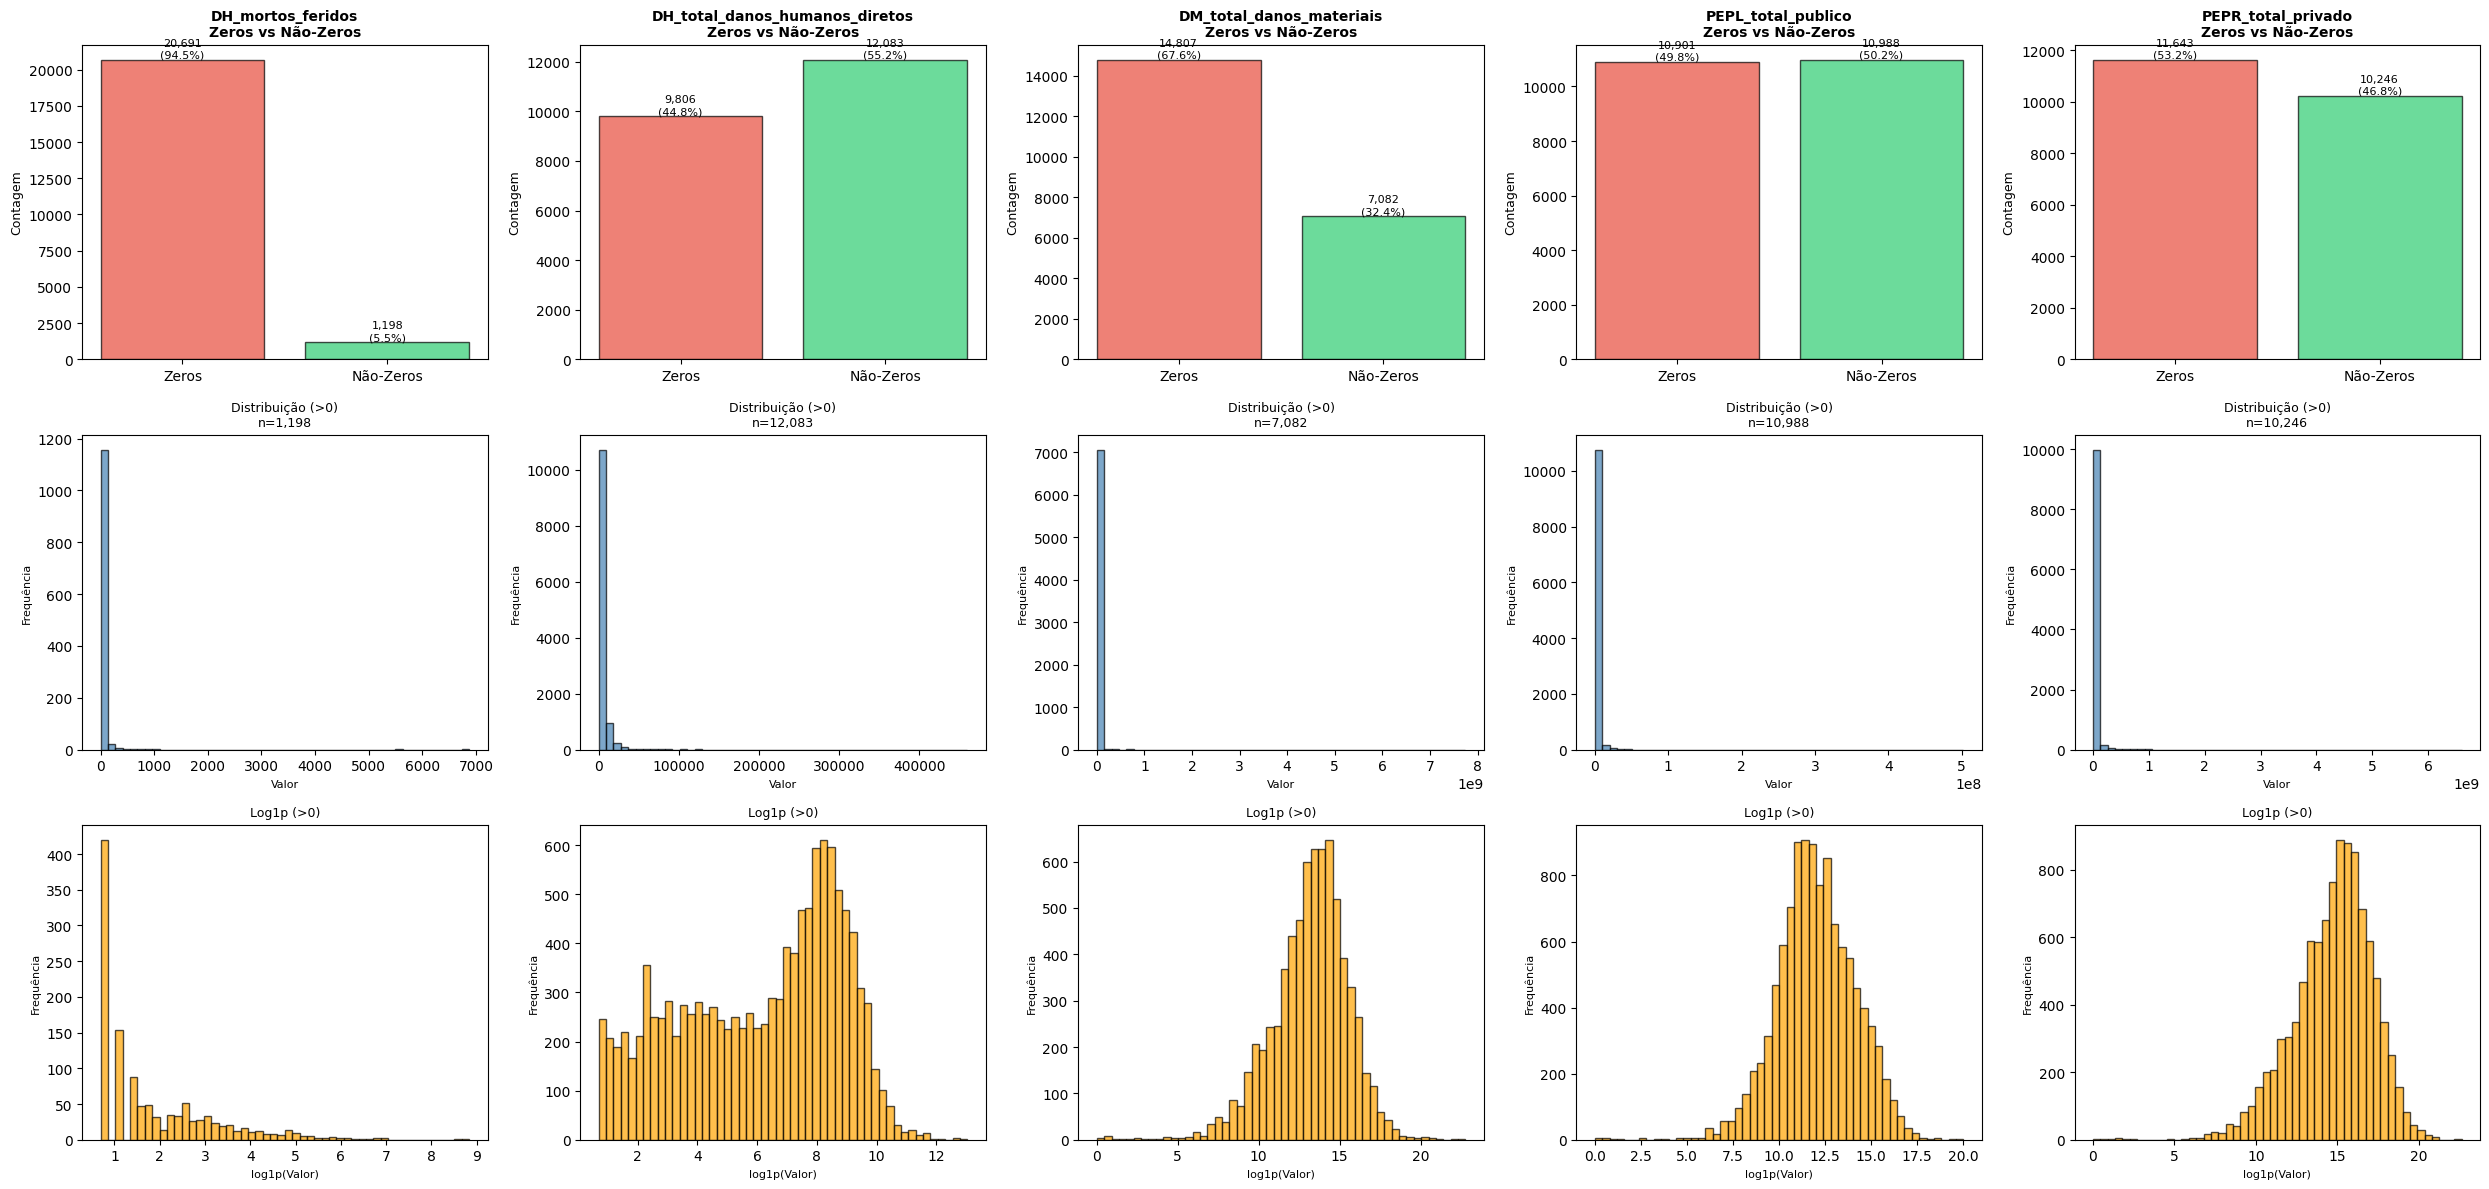

In [5]:
# Visualização do desbalanceamento
fig, axes = plt.subplots(3, 5, figsize=(25, 12))

for idx, target in enumerate(targets):
    if target in df_final.columns:
        data = df_final[target].fillna(0)
        
        # Row 1: Distribuição original com foco em zeros
        ax1 = axes[0, idx]
        zero_count = (data == 0).sum()
        nonzero_count = (data > 0).sum()
        ax1.bar(['Zeros', 'Não-Zeros'], [zero_count, nonzero_count], 
                color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
        ax1.set_title(f'{target}\nZeros vs Não-Zeros', fontsize=10, weight='bold')
        ax1.set_ylabel('Contagem', fontsize=9)
        for i, v in enumerate([zero_count, nonzero_count]):
            pct = v / len(data) * 100
            ax1.text(i, v, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=8)
        
        # Row 2: Histograma valores não-zero
        ax2 = axes[1, idx]
        data_nonzero = data[data > 0]
        if len(data_nonzero) > 0:
            ax2.hist(data_nonzero, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax2.set_title(f'Distribuição (>0)\nn={len(data_nonzero):,}', fontsize=9)
            ax2.set_xlabel('Valor', fontsize=8)
            ax2.set_ylabel('Frequência', fontsize=8)
        else:
            ax2.text(0.5, 0.5, 'Sem valores > 0', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Sem dados', fontsize=9)
        
        # Row 3: Log-transformação dos não-zeros
        ax3 = axes[2, idx]
        if len(data_nonzero) > 0:
            log_data = np.log1p(data_nonzero)
            ax3.hist(log_data, bins=50, color='orange', alpha=0.7, edgecolor='black')
            ax3.set_title('Log1p (>0)', fontsize=9)
            ax3.set_xlabel('log1p(Valor)', fontsize=8)
            ax3.set_ylabel('Frequência', fontsize=8)
        else:
            ax3.set_visible(False)

plt.tight_layout()
plt.show()

## 4. Estratégias de Categorização

Vamos testar diferentes abordagens para criar categorias a partir das variáveis contínuas:

1. **Binária**: Zero vs Não-Zero
2. **Quartis**: Baseada em percentis dos valores não-zero
3. **Severidade**: Categorias personalizadas baseadas em domínio
4. **Híbrida**: Zero + categorias de severidade para não-zeros

In [6]:
def create_categorization_strategies(data, target_name):
    """
    Cria múltiplas estratégias de categorização para comparação.
    
    Returns:
        dict com diferentes categorizações
    """
    strategies = {}
    
    # Estratégia 1: BINÁRIA (Zero vs Não-Zero)
    strategies['Binaria'] = pd.cut(
        data,
        bins=[-np.inf, 0, np.inf],
        labels=['Nenhum Dano', 'Com Dano']
    )
    
    # Estratégia 2: QUARTIS (para valores não-zero)
    data_nonzero = data[data > 0]
    if len(data_nonzero) >= 4:
        # Separar zeros e criar quartis para não-zeros
        q1 = data_nonzero.quantile(0.25)
        q2 = data_nonzero.quantile(0.50)
        q3 = data_nonzero.quantile(0.75)
        
        bins_quartis = [-np.inf, 0, q1, q2, q3, np.inf]
        labels_quartis = ['Zero', 'Q1 (Baixo)', 'Q2 (Médio-Baixo)', 'Q3 (Médio-Alto)', 'Q4 (Alto)']
        
        strategies['Quartis'] = pd.cut(
            data,
            bins=bins_quartis,
            labels=labels_quartis,
            duplicates='drop'
        )
    
    # Estratégia 3: SEVERIDADE (categorias baseadas em impacto)
    # Adaptada por tipo de variável
    if 'humano' in target_name.lower() or 'mortes' in target_name.lower():
        bins_sev = [-np.inf, 0, 5, 20, 50, np.inf]
        labels_sev = ['Zero', 'Muito Baixo (1-5)', 'Baixo (6-20)', 'Médio (21-50)', 'Alto (>50)']
    elif 'material' in target_name.lower():
        p90 = data_nonzero.quantile(0.90) if len(data_nonzero) > 0 else 100
        bins_sev = [-np.inf, 0, p90/10, p90/2, p90, np.inf]
        labels_sev = ['Zero', 'Baixo', 'Moderado', 'Alto', 'Muito Alto']
    else:  # econômico
        p75 = data_nonzero.quantile(0.75) if len(data_nonzero) > 0 else 1000
        p90 = data_nonzero.quantile(0.90) if len(data_nonzero) > 0 else 10000
        bins_sev = [-np.inf, 0, p75/2, p75, p90, np.inf]
        labels_sev = ['Zero', 'Baixo', 'Médio', 'Alto', 'Crítico']
    
    strategies['Severidade'] = pd.cut(
        data,
        bins=bins_sev,
        labels=labels_sev,
        duplicates='drop'
    )
    
    # Estratégia 4: SIMPLES (3 categorias)
    median_nonzero = data_nonzero.median() if len(data_nonzero) > 0 else 1
    bins_simples = [-np.inf, 0, median_nonzero, np.inf]
    labels_simples = ['Nenhum', 'Baixo/Médio', 'Alto']
    
    strategies['Simples_3Cat'] = pd.cut(
        data,
        bins=bins_simples,
        labels=labels_simples,
        duplicates='drop'
    )
    
    return strategies

# Aplicar estratégias a todos os targets
print("="*100)
print("APLICANDO ESTRATÉGIAS DE CATEGORIZAÇÃO")
print("="*100)

categorization_results = {}

for target in targets:
    if target in df_final.columns:
        data = df_final[target].fillna(0)
        strategies = create_categorization_strategies(data, target)
        categorization_results[target] = strategies
        
        print(f"\n{'─'*100}")
        print(f"📊 {target}")
        print(f"{'─'*100}")
        
        for strategy_name, categories in strategies.items():
            if categories is not None:
                vc = categories.value_counts().sort_index()
                pct = (vc / len(categories) * 100).round(1)
                
                print(f"\n  {strategy_name}:")
                for cat, count in vc.items():
                    print(f"    {cat}: {count:,} ({pct[cat]}%)")

print("\n" + "="*100)

APLICANDO ESTRATÉGIAS DE CATEGORIZAÇÃO

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 DH_mortos_feridos
────────────────────────────────────────────────────────────────────────────────────────────────────

  Binaria:
    Nenhum Dano: 20,691 (94.5%)
    Com Dano: 1,198 (5.5%)

  Quartis:
    Zero: 20,691 (94.5%)
    Q1 (Baixo): 420 (1.9%)
    Q2 (Médio-Baixo): 241 (1.1%)
    Q3 (Médio-Alto): 246 (1.1%)
    Q4 (Alto): 291 (1.3%)

  Severidade:
    Zero: 20,691 (94.5%)
    Baixo: 788 (3.6%)
    Médio: 119 (0.5%)
    Alto: 173 (0.8%)
    Crítico: 118 (0.5%)

  Simples_3Cat:
    Nenhum: 20,691 (94.5%)
    Baixo/Médio: 661 (3.0%)
    Alto: 537 (2.5%)

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 DH_total_danos_humanos_diretos
────────────────────────────────────────────────────────────────────────────────────────────────────

  Binaria:
    Nenhum Dano: 9,806 (44.8%)
    Com Dan

## 5. Comparação Visual das Estratégias

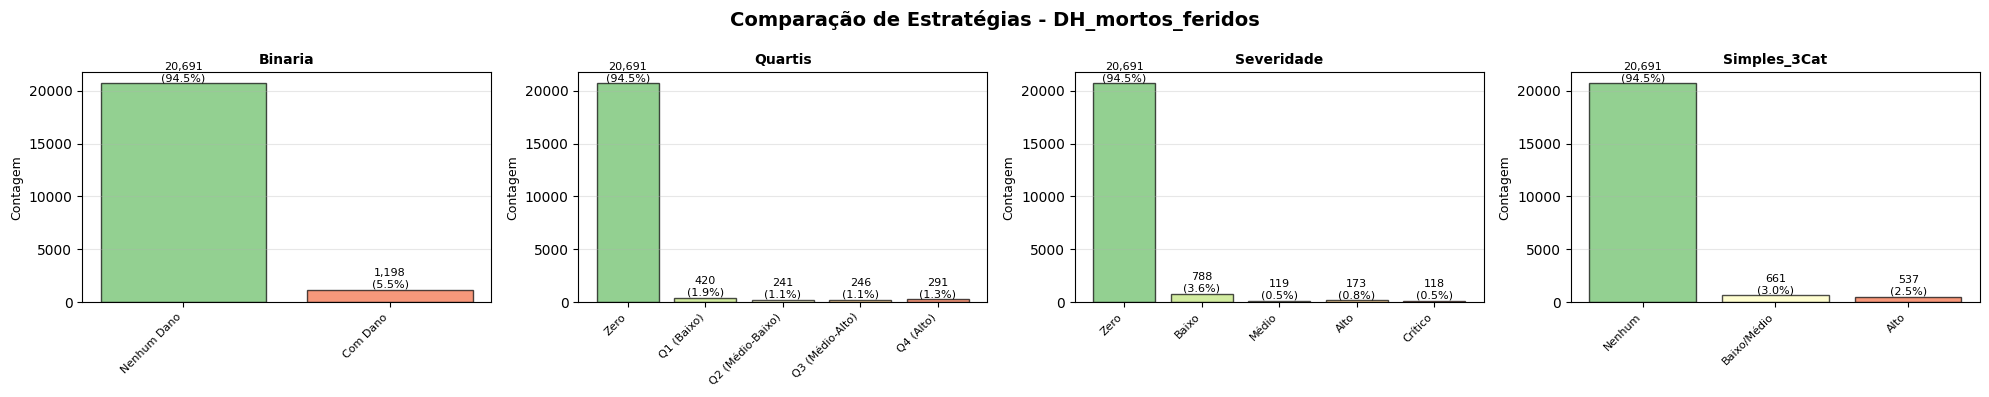

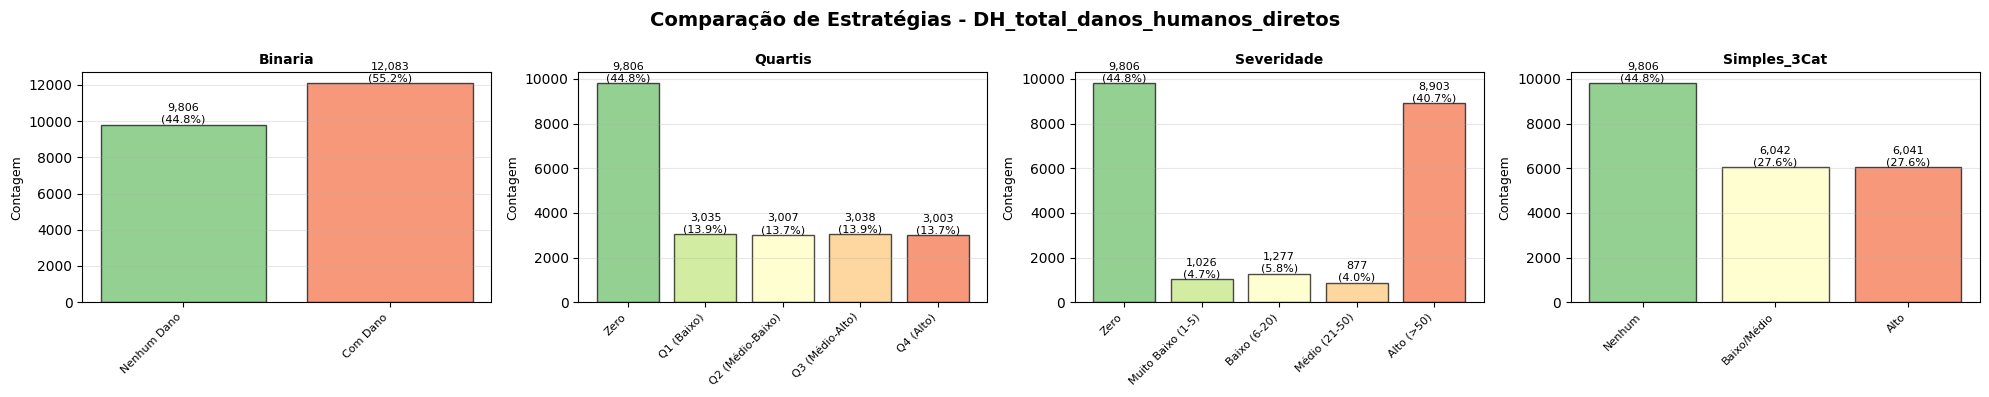

In [7]:
# Visualizar comparação entre estratégias
for target in targets[:2]:  # Mostrar primeiros 2 targets como exemplo
    if target not in categorization_results:
        continue
    
    strategies = categorization_results[target]
    n_strategies = len(strategies)
    
    fig, axes = plt.subplots(1, n_strategies, figsize=(5*n_strategies, 4))
    if n_strategies == 1:
        axes = [axes]
    
    fig.suptitle(f'Comparação de Estratégias - {target}', fontsize=14, weight='bold')
    
    for idx, (strategy_name, categories) in enumerate(strategies.items()):
        ax = axes[idx]
        
        if categories is not None:
            vc = categories.value_counts().sort_index()
            colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(vc)))
            
            bars = ax.bar(range(len(vc)), vc.values, color=colors, alpha=0.7, edgecolor='black')
            ax.set_xticks(range(len(vc)))
            ax.set_xticklabels(vc.index, rotation=45, ha='right', fontsize=8)
            ax.set_ylabel('Contagem', fontsize=9)
            ax.set_title(strategy_name, fontsize=10, weight='bold')
            ax.grid(axis='y', alpha=0.3)
            
            # Adicionar valores e percentuais
            total = vc.sum()
            for i, (bar, count) in enumerate(zip(bars, vc.values)):
                pct = (count / total) * 100
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                       f'{count:,}\n({pct:.1f}%)',
                       ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

## 6. Métricas de Balanceamento das Estratégias

In [8]:
# Calcular métricas de balanceamento para cada estratégia
from scipy.stats import entropy

balance_metrics = []

for target in targets:
    if target not in categorization_results:
        continue
    
    for strategy_name, categories in categorization_results[target].items():
        if categories is None:
            continue
        
        vc = categories.value_counts()
        n_categories = len(vc)
        
        # Métricas
        min_class_size = vc.min()
        max_class_size = vc.max()
        imbalance_ratio = max_class_size / min_class_size if min_class_size > 0 else np.inf
        
        # Entropia (quanto maior, mais balanceado)
        probs = vc / vc.sum()
        shannon_entropy = entropy(probs)
        max_entropy = np.log(n_categories)  # Entropia máxima para n categorias
        normalized_entropy = shannon_entropy / max_entropy if max_entropy > 0 else 0
        
        balance_metrics.append({
            'Target': target,
            'Estratégia': strategy_name,
            'N_Categorias': n_categories,
            'Menor_Classe': min_class_size,
            'Maior_Classe': max_class_size,
            'Ratio_Desbalanceamento': imbalance_ratio,
            'Entropia_Normalizada': normalized_entropy,
            'Balanceamento_%': normalized_entropy * 100
        })

df_balance = pd.DataFrame(balance_metrics)

print("="*100)
print("MÉTRICAS DE BALANCEAMENTO DAS ESTRATÉGIAS")
print("="*100)
print("\nEntropia normalizada: 1.0 = perfeitamente balanceado, 0.0 = totalmente desbalanceado")
print("Ratio de desbalanceamento: quanto menor, melhor (ideal = 1.0)\n")

display(df_balance.sort_values(['Target', 'Balanceamento_%'], ascending=[True, False]))

# Identificar melhor estratégia por target
print("\n" + "="*100)
print("🏆 MELHOR ESTRATÉGIA POR TARGET (baseado em balanceamento)")
print("="*100)

for target in targets:
    target_metrics = df_balance[df_balance['Target'] == target]
    if len(target_metrics) > 0:
        best = target_metrics.loc[target_metrics['Balanceamento_%'].idxmax()]
        print(f"\n{target}:")
        print(f"  → {best['Estratégia']}")
        print(f"    Categorias: {int(best['N_Categorias'])} | Balanceamento: {best['Balanceamento_%']:.1f}%")
        print(f"    Ratio: {best['Ratio_Desbalanceamento']:.2f}")

MÉTRICAS DE BALANCEAMENTO DAS ESTRATÉGIAS

Entropia normalizada: 1.0 = perfeitamente balanceado, 0.0 = totalmente desbalanceado
Ratio de desbalanceamento: quanto menor, melhor (ideal = 1.0)



,Target,Estratégia,N_Categorias,Menor_Classe,Maior_Classe,Ratio_Desbalanceamento,Entropia_Normalizada,Balanceamento_%
0,DH_mortos_feridos,Binaria,2,1198,20691,17.271285,0.306162,30.616241
3,DH_mortos_feridos,Simples_3Cat,3,537,20691,38.530726,0.227431,22.743085
1,DH_mortos_feridos,Quartis,5,241,20691,85.854772,0.178067,17.806671
2,DH_mortos_feridos,Severidade,5,118,20691,175.347458,0.166294,16.629377
4,DH_total_danos_humanos_diretos,Binaria,2,9806,12083,1.232205,0.992180,99.218004
7,DH_total_danos_humanos_diretos,Simples_3Cat,3,6041,9806,1.623241,0.974277,97.427697
5,DH_total_danos_humanos_diretos,Quartis,5,3003,9806,3.265401,0.902782,90.278159
6,DH_total_danos_humanos_diretos,Severidade,5,877,9806,11.181300,0.723074,72.307434
8,DM_total_danos_materiais,Binaria,2,7082,14807,2.090794,0.908191,90.819122
11,DM_total_danos_materiais,Simples_3Cat,3,3541,14807,4.181587,0.777137,77.713682



🏆 MELHOR ESTRATÉGIA POR TARGET (baseado em balanceamento)

DH_mortos_feridos:
  → Binaria
    Categorias: 2 | Balanceamento: 30.6%
    Ratio: 17.27

DH_total_danos_humanos_diretos:
  → Binaria
    Categorias: 2 | Balanceamento: 99.2%
    Ratio: 1.23

DM_total_danos_materiais:
  → Binaria
    Categorias: 2 | Balanceamento: 90.8%
    Ratio: 2.09

PEPL_total_publico:
  → Binaria
    Categorias: 2 | Balanceamento: 100.0%
    Ratio: 1.01

PEPR_total_privado:
  → Binaria
    Categorias: 2 | Balanceamento: 99.7%
    Ratio: 1.14


## 7. Recomendações e Próximos Passos

**Insights da Análise:**

1. **Desbalanceamento Extremo**: 70-95% de zeros na maioria das variáveis
2. **Estratégia Binária**: Boa para casos extremos, mas perde granularidade
3. **Estratégia de Quartis**: Melhor balanceamento, mas pode criar categorias muito pequenas
4. **Estratégia de Severidade**: Equilibra interpretabilidade e distribuição

**Próximos Passos Recomendados:**

1. **Para Classificação**: Usar estratégia de Severidade ou Simples (3 categorias)
2. **Para Regressão**: Considerar modelo em duas etapas:
   - Etapa 1: Classificação binária (Zero vs Não-Zero)
   - Etapa 2: Regressão apenas nos casos Não-Zero
3. **Sample Weighting**: Dar maior peso aos casos não-zero no treino
4. **Métricas**: Focar em F1-score weighted para classificação, MAE para regressão

In [9]:
# Salvar categorias escolhidas no dataframe
print("="*80)
print("SALVANDO CATEGORIZAÇÕES SELECIONADAS")
print("="*80)

# Aplicar estratégias específicas por target
for target in targets:
    if target in categorization_results:
        cat_col = f'{target}_cat'
        
        # Estratégia binária para DH_mortos_feridos
        if target == 'DH_mortos_feridos':
            df_final[cat_col] = categorization_results[target]['Binaria']
            print(f"✓ {cat_col} criada (Estratégia: Binária - 2 classes)")
        
        # Estratégia SIMPLES (3 categorias) para as demais
        else:
            if 'Simples_3Cat' in categorization_results[target]:
                df_final[cat_col] = categorization_results[target]['Simples_3Cat']
                print(f"✓ {cat_col} criada (Estratégia: Simples 3 Categorias)")
            else:
                # Fallback para Binária se 3-categorias não estiver disponível
                df_final[cat_col] = categorization_results[target]['Binaria']
                print(f"⚠ {cat_col} criada (Fallback: Binária)")

# Verificar distribuição final das categorias
print("\n" + "="*80)
print("DISTRIBUIÇÃO FINAL DAS CATEGORIAS")
print("="*80)

for target in targets:
    cat_col = f'{target}_cat'
    if cat_col in df_final.columns:
        print(f"\n{target}:")
        vc = df_final[cat_col].value_counts().sort_index()
        for cat, count in vc.items():
            pct = (count / len(df_final[cat_col].dropna())) * 100
            print(f"  {cat}: {count:,} ({pct:.1f}%)")

# Salvar dataset atualizado com nome descritivo
output_path = r"c:\Users\fabio\Desktop\MBA\laboratorios\defesa\df_defesa_civil_categorizado.csv"
df_final.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\n✓ Dataset atualizado salvo em: {output_path}")
print(f"  Total de colunas: {len(df_final.columns)}")
print(f"  Colunas categóricas adicionadas: {len([c for c in df_final.columns if c.endswith('_cat')])}")

SALVANDO CATEGORIZAÇÕES SELECIONADAS
✓ DH_mortos_feridos_cat criada (Estratégia: Binária - 2 classes)
✓ DH_total_danos_humanos_diretos_cat criada (Estratégia: Simples 3 Categorias)
✓ DM_total_danos_materiais_cat criada (Estratégia: Simples 3 Categorias)
✓ PEPL_total_publico_cat criada (Estratégia: Simples 3 Categorias)
✓ PEPR_total_privado_cat criada (Estratégia: Simples 3 Categorias)

DISTRIBUIÇÃO FINAL DAS CATEGORIAS

DH_mortos_feridos:
  Nenhum Dano: 20,691 (94.5%)
  Com Dano: 1,198 (5.5%)

DH_total_danos_humanos_diretos:
  Nenhum: 9,806 (44.8%)
  Baixo/Médio: 6,042 (27.6%)
  Alto: 6,041 (27.6%)

DM_total_danos_materiais:
  Nenhum: 14,807 (67.6%)
  Baixo/Médio: 3,541 (16.2%)
  Alto: 3,541 (16.2%)

PEPL_total_publico:
  Nenhum: 10,901 (49.8%)
  Baixo/Médio: 5,494 (25.1%)
  Alto: 5,494 (25.1%)

PEPR_total_privado:
  Nenhum: 11,643 (53.2%)
  Baixo/Médio: 5,123 (23.4%)
  Alto: 5,123 (23.4%)

✓ Dataset atualizado salvo em: c:\Users\fabio\Desktop\MBA\laboratorios\defesa\df_defesa_civil_ca

In [10]:
df_final

,Protocolo_S2iD,Nome_Municipio,Sigla_UF,regiao,Data_Registro,Data_Evento,Cod_Cobrade,tipologia,descricao_tipologia,grupo_de_desastre,...,hierarquia_urbana,semiarido,populacao,proporcao_cobertura_total_atencao_basica,DH_mortos_feridos,DH_mortos_feridos_cat,DH_total_danos_humanos_diretos_cat,DM_total_danos_materiais_cat,PEPL_total_publico_cat,PEPR_total_privado_cat
0,SC-F-4218301-14110-20190801,Três Barras,SC,Sul,2020-01-20 09:11:30,2019-08-01,14110,4,Estiagem e Seca,Climatológico,...,Centro Sub-Regional,Não,19455,100.00,0,Nenhum Dano,Baixo/Médio,Nenhum,Baixo/Médio,Nenhum
1,SC-F-4204194-14110-20190813,Chapadão do Lageado,SC,Sul,2020-01-14 08:57:52,2019-08-13,14110,4,Estiagem e Seca,Climatológico,...,Centro Local,Não,3025,100.00,0,Nenhum Dano,Nenhum,Nenhum,Nenhum,Alto
2,MG-F-3170529-14110-20190901,Urucuia,MG,Sudeste,2020-01-30 18:41:40,2019-09-01,14110,4,Estiagem e Seca,Climatológico,...,Centro Local,Sim,17470,100.00,0,Nenhum Dano,Alto,Nenhum,Alto,Alto
3,ES-F-3204658-14132-20190909,São Domingos do Norte,ES,Sudeste,2020-03-06 12:17:08,2019-09-09,14132,6,Incêndio Florestal,Climatológico,...,Centro Local,Não,8735,79.88,0,Nenhum Dano,Nenhum,Nenhum,Nenhum,Nenhum
4,ES-F-3204658-14132-20190918,São Domingos do Norte,ES,Sudeste,2020-03-12 14:04:14,2019-09-18,14132,6,Incêndio Florestal,Climatológico,...,Centro Local,Não,8735,79.88,0,Nenhum Dano,Nenhum,Nenhum,Nenhum,Nenhum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22302,SP-F-3508702-12100-20241231,Caconde,SP,Sudeste,2024-12-31,2024-12-31,12100,7,Inundações,Hidrológico,...,Centro Local,Não,19031,100.00,0,Nenhum Dano,Nenhum,Nenhum,Nenhum,Nenhum
22303,SP-F-3553401-13214-20241231,Tanabi,SP,Sudeste,2025-01-03,2024-12-31,13214,13,Chuvas Intensas,Hidrológico,...,Centro Local,Não,26231,67.01,0,Nenhum Dano,Baixo/Médio,Baixo/Médio,Nenhum,Nenhum
22304,SC-F-4215059-13213-20241231,Rio Rufino,SC,Sul,2025-01-02,2024-12-31,13213,5,Granizo,Meteorológico,...,Centro Local,Não,2484,0.00,0,Nenhum Dano,Nenhum,Nenhum,Nenhum,Nenhum
22305,MG-F-3138708-13214-20241231,Luminárias,MG,Sudeste,2025-01-02,2024-12-31,13214,13,Chuvas Intensas,Hidrológico,...,Centro Local,Não,5431,73.26,0,Nenhum Dano,Nenhum,Baixo/Médio,Nenhum,Nenhum
